In [7]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pandas import read_csv
import pandas as pd 
import numpy as np 
from datetime import datetime

# stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

# plotting
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt

# settings
plt.style.use('seaborn')
%matplotlib inline
data = pd.read_csv('dataQuery1Clustered.csv', header=0)
data = data.set_index('Date')

In [4]:
import sklearn.mixture as mix
col = 'Long Interest Rate'
select = data.dropna()

ft_cols = ['Real Earnings', 'Long Interest Rate', 'Cluster']
# ft_cols = [f1, f2, f3, 'Cluster']
X = select[ft_cols].values


model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)
# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()
    

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)


Means and vars of each hidden state
0th hidden state
mean =  [32.68747368  4.49873684  4.        ]
var =  [3.30706830e+00 1.41580993e+00 1.00000000e-06]

1th hidden state
mean =  [38.16304536  7.94156272  1.38274007]
var =  [10.21339047  7.93079431  0.53187881]

2th hidden state
mean =  [45.73280841  8.41038483  3.        ]
var =  [4.43045784e+00 2.57386318e+00 1.00000000e-06]



In [6]:
p=print
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=select.index)
          .join(select, how='inner')
          .assign(mkt_cret=select.Cluster.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
p(states.head())

         Date  states  Real Earnings  Long Interest Rate  Cluster  mkt_cret
0  1916-08-01       0          30.09                4.16        4         4
1  1916-09-01       0          30.79                4.17        4         8
2  1916-10-01       0          31.44                4.19        4        12
3  1916-11-01       0          32.07                4.20        4        16
4  1916-12-01       0          32.95                4.21        4        20


In [8]:
states.to_csv('df_states.csv')

         Date  states  Real Earnings  Long Interest Rate  Cluster  mkt_cret
0  1916-08-01       0          30.09                4.16        4         4
1  1916-09-01       0          30.79                4.17        4         8
2  1916-10-01       0          31.44                4.19        4        12
3  1916-11-01       0          32.07                4.20        4        16
4  1916-12-01       0          32.95                4.21        4        20


In [28]:
states = pd.read_csv('df_states.csv', header=0)
#states = states.set_index('Date')
states

,Unnamed: 0,Date,states,Real Earnings,Long Interest Rate,Cluster,mkt_cret
0,0,1916-08-01,0,30.09,4.16,4,4
1,1,1916-09-01,0,30.79,4.17,4,8
2,2,1916-10-01,0,31.44,4.19,4,12
3,3,1916-11-01,0,32.07,4.20,4,16
4,4,1916-12-01,0,32.95,4.21,4,20
...,...,...,...,...,...,...,...
432,432,2003-05-01,2,45.12,3.57,3,969
433,433,2003-06-01,2,46.99,3.33,3,972
434,434,2003-07-01,2,48.76,3.98,3,975
435,435,2008-10-01,1,41.06,3.81,2,977


In [29]:
states1 = states[['states', 'Real Earnings', 'Long Interest Rate']]
states1

,states,Real Earnings,Long Interest Rate
0,0,30.09,4.16
1,0,30.79,4.17
2,0,31.44,4.19
3,0,32.07,4.20
4,0,32.95,4.21
...,...,...,...
432,2,45.12,3.57
433,2,46.99,3.33
434,2,48.76,3.98
435,1,41.06,3.81


## Local 1 - Random Forest

In [30]:
from sklearn.model_selection import train_test_split
y = states1['states']
training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .25, random_state = 42)

In [31]:
X = states1.drop(['states'], axis = 1)

In [32]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
normed_train_data = pd.DataFrame(sc.fit_transform(training), columns = X.columns)
normed_test_data = pd.DataFrame(sc.fit_transform(testing), columns = X.columns)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf=RandomForestClassifier()
clf.fit(training, training_labels)

RandomForestClassifier()

In [35]:
preds = clf.predict(testing)

In [36]:
print (clf.score(training, training_labels))
print(clf.score(testing, testing_labels))

1.0
0.9727272727272728


In [39]:
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
metrics.confusion_matrix(testing_labels, preds,  labels = [1, 2, 3])

array([[66,  1,  0],
       [ 1, 14,  0],
       [ 0,  0,  0]], dtype=int64)

In [44]:
from sklearn.metrics import classification_report
print(classification_report(testing_labels, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       0.99      0.97      0.98        68
           2       0.93      0.93      0.93        15

    accuracy                           0.97       110
   macro avg       0.96      0.97      0.96       110
weighted avg       0.97      0.97      0.97       110



## Hidden Markov Model- Random Forest
We use HMM to re-state folowing datapoints

In [107]:
newStates = pd.read_csv('dataQuery2.csv', header=0)
newStates = newStates.set_index('Date')
newStates

,Real Earnings,Long Interest Rate
Date,,
1871-01-01,8.02,5.32
1871-05-01,8.14,5.33
1871-06-01,8.27,5.34
1871-07-01,8.27,5.34
1871-08-01,8.40,5.34
...,...,...
2009-07-01,10.66,3.56
2009-08-01,12.57,3.59
2009-09-01,14.51,3.40


In [104]:
newStates = newStates[['Real Earnings', 'Long Interest Rate']]
newStates

,Real Earnings,Long Interest Rate
0,8.02,5.32
1,8.14,5.33
2,8.27,5.34
3,8.27,5.34
4,8.40,5.34
...,...,...
1452,10.66,3.56
1453,12.57,3.59
1454,14.51,3.40
1455,29.30,3.39


In [73]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
newStates = scaler.fit_transform(newStates)

In [105]:
new_df=pd.DataFrame(newStates, columns=['Real Earnings', 'Long Interest Rate']) 
new_df

,Real Earnings,Long Interest Rate
0,8.02,5.32
1,8.14,5.33
2,8.27,5.34
3,8.27,5.34
4,8.40,5.34
...,...,...
1452,10.66,3.56
1453,12.57,3.59
1454,14.51,3.40
1455,29.30,3.39


In [108]:
import sklearn.mixture as mix
col = 'Long Interest Rate'
select = new_df.dropna()

ft_cols = ['Real Earnings', 'Long Interest Rate']
# ft_cols = [f1, f2, f3, 'Cluster']
X = select[ft_cols].values


model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)
# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()
    

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)


Means and vars of each hidden state
0th hidden state
mean =  [24.18537328  3.35860709]
var =  [29.78339836  0.5200946 ]

1th hidden state
mean =  [38.90171174  7.72038213]
var =  [23.35950378  6.79851986]

2th hidden state
mean =  [12.98460968  3.57568924]
var =  [12.63703299  0.62590905]



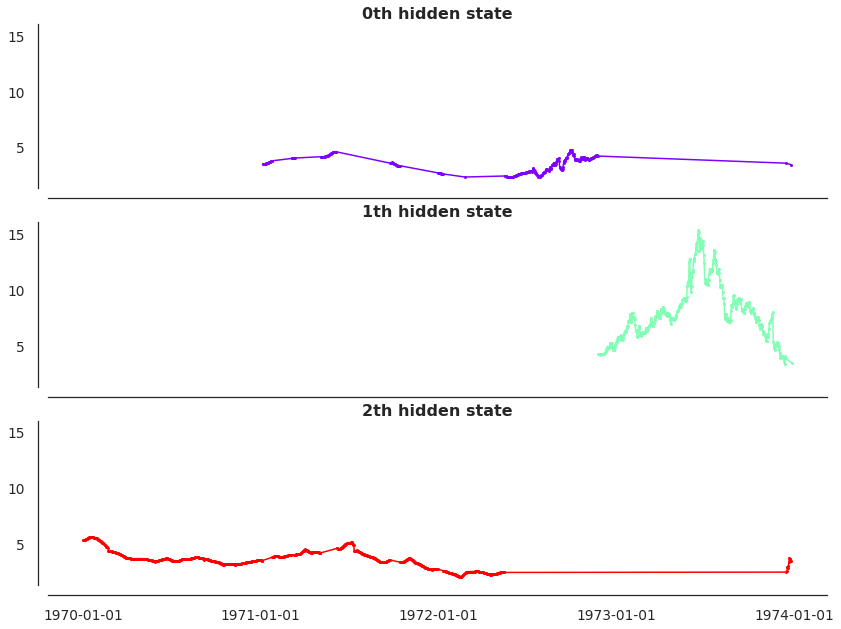

In [109]:
from matplotlib import cm
from matplotlib.dates import YearLocator, MonthLocator
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
#fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

In [110]:
p=print
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['newStates'], index=select.index)
          .join(select, how='inner')
          #.assign(mkt_cret=select.Cluster.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
p(states.head())

   Date  newStates  Real Earnings  Long Interest Rate
0     0          2           8.02                5.32
1     1          2           8.14                5.33
2     2          2           8.27                5.34
3     3          2           8.27                5.34
4     4          2           8.40                5.34


In [111]:
p(states.head())
newStatesDf = states

   Date  newStates  Real Earnings  Long Interest Rate
0     0          2           8.02                5.32
1     1          2           8.14                5.33
2     2          2           8.27                5.34
3     3          2           8.27                5.34
4     4          2           8.40                5.34


In [113]:
newStatesDf.to_csv('df_states_updated.csv')

## Local 2 - Random Forest
We change the the states in the data and now we evaluate the model

In [129]:
states2 = pd.read_csv('df_states_updated.csv', header=0)
#states = states.set_index('Date')
states2

,newStates,Real Earnings,Long Interest Rate
0,2,8.02,5.32
1,2,8.14,5.33
2,2,8.27,5.34
3,2,8.27,5.34
4,2,8.40,5.34
...,...,...,...
1889,2,45.12,3.57
1890,2,46.99,3.33
1891,2,48.76,3.98
1892,1,41.06,3.81


In [131]:
X = states2.drop(['newStates'], axis = 1)

In [132]:
from sklearn.model_selection import train_test_split
y = states2['newStates']
training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .25, random_state = 42)

In [95]:
# X = states2.drop(['states'], axis = 1)
# # Normalize the data
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# normed_train_data = pd.DataFrame(sc.fit_transform(training), columns = X.columns)
# normed_test_data = pd.DataFrame(sc.fit_transform(testing), columns = X.columns)

In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf=RandomForestClassifier()
clf.fit(training, training_labels)

RandomForestClassifier()

In [134]:
preds = clf.predict(testing)

In [135]:
print (clf.score(training, training_labels))
print(clf.score(testing, testing_labels))

0.9464788732394366
0.9135021097046413


In [136]:
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
metrics.confusion_matrix(testing_labels, preds,  labels = [1, 2, 3])

array([[142,  19,   0],
       [ 12, 216,   0],
       [  0,   0,   0]], dtype=int64)

In [137]:
from sklearn.metrics import classification_report
print(classification_report(testing_labels, preds))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        85
           1       0.87      0.88      0.87       161
           2       0.92      0.95      0.93       228

    accuracy                           0.91       474
   macro avg       0.93      0.90      0.91       474
weighted avg       0.92      0.91      0.91       474



## Local model 3: Current Scenario: New accuracy < Old accuracy
As the new accuracy is less than old accuracy we now only train the new dataset.

In [164]:
states3 = pd.read_csv('df_states_newDatapoints.csv', header=0)
#states = states.set_index('Date')
states3

,newStates,Real Earnings,Long Interest Rate
0,2,8.02,5.32
1,2,8.14,5.33
2,2,8.27,5.34
3,2,8.27,5.34
4,2,8.40,5.34
...,...,...,...
1452,2,10.66,3.56
1453,2,12.57,3.59
1454,2,14.51,3.40
1455,0,29.30,3.39


In [165]:
from sklearn.model_selection import train_test_split
y = states3['newStates']
training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .25, random_state = 42)

In [166]:
X = states3.drop(['newStates'], axis = 1)

In [159]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
normed_train_data = pd.DataFrame(sc.fit_transform(training), columns = X.columns)
normed_test_data = pd.DataFrame(sc.fit_transform(testing), columns = X.columns)

RandomForestClassifier()

In [167]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf=RandomForestClassifier()
clf.fit(training, training_labels)

RandomForestClassifier()

In [168]:
preds = clf.predict(testing)

In [169]:
print (clf.score(training, training_labels))
print(clf.score(testing, testing_labels))

1.0
0.9972602739726028


In [170]:
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
metrics.confusion_matrix(testing_labels, preds,  labels = [1, 2, 3])

array([[105,   0,   0],
       [  0, 191,   0],
       [  0,   0,   0]], dtype=int64)

In [171]:
from sklearn.metrics import classification_report
print(classification_report(testing_labels, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       1.00      0.99      1.00       106
           2       1.00      1.00      1.00       191

    accuracy                           1.00       365
   macro avg       1.00      1.00      1.00       365
weighted avg       1.00      1.00      1.00       365



# Support Vector Machine

## Local model 1 - SVM

In [189]:
states = pd.read_csv('df_states.csv', header=0)
#states = states.set_index('Date')
states1 = states[['states', 'Real Earnings', 'Long Interest Rate']]
states1

,states,Real Earnings,Long Interest Rate
0,0,30.09,4.16
1,0,30.79,4.17
2,0,31.44,4.19
3,0,32.07,4.20
4,0,32.95,4.21
...,...,...,...
432,2,45.12,3.57
433,2,46.99,3.33
434,2,48.76,3.98
435,1,41.06,3.81


In [190]:
from sklearn.model_selection import train_test_split
y = states1['states']
X = states1.drop(['states'], axis = 1)

In [191]:
training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .25, random_state = 42)

In [192]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(training, training_labels)

#Predict the response for test dataset
y_pred = clf.predict(testing)

In [194]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(testing_labels, y_pred))

Accuracy: 0.9636363636363636


In [203]:
from sklearn.metrics import f1_score
print("f-score testing macro: " , f1_score(testing_labels, y_pred, average='macro') )

f-score testing macro:  0.951731080667046


## Hidden Markov Model- SVM
We use HMM to re-state folowing datapoints

In [209]:
newStates = pd.read_csv('dataQuery2.csv', header=0)
newStates = newStates.set_index('Date')

In [210]:
newStates = newStates[['Real Earnings', 'Long Interest Rate']]

In [208]:
# # Normalize the data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# newStates = scaler.fit_transform(newStates)
# new_df=pd.DataFrame(newStates, columns=['Real Earnings', 'Long Interest Rate']) 
# new_df

In [212]:
import sklearn.mixture as mix
col = 'Long Interest Rate'
select = new_df.dropna()

ft_cols = ['Real Earnings', 'Long Interest Rate']
# ft_cols = [f1, f2, f3, 'Cluster']
X = select[ft_cols].values


model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)
# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

Means and vars of each hidden state
0th hidden state
mean =  [24.18537328  3.35860709]
var =  [29.78339836  0.5200946 ]

1th hidden state
mean =  [38.90171174  7.72038213]
var =  [23.35950378  6.79851986]

2th hidden state
mean =  [12.98460968  3.57568924]
var =  [12.63703299  0.62590905]



In [214]:
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

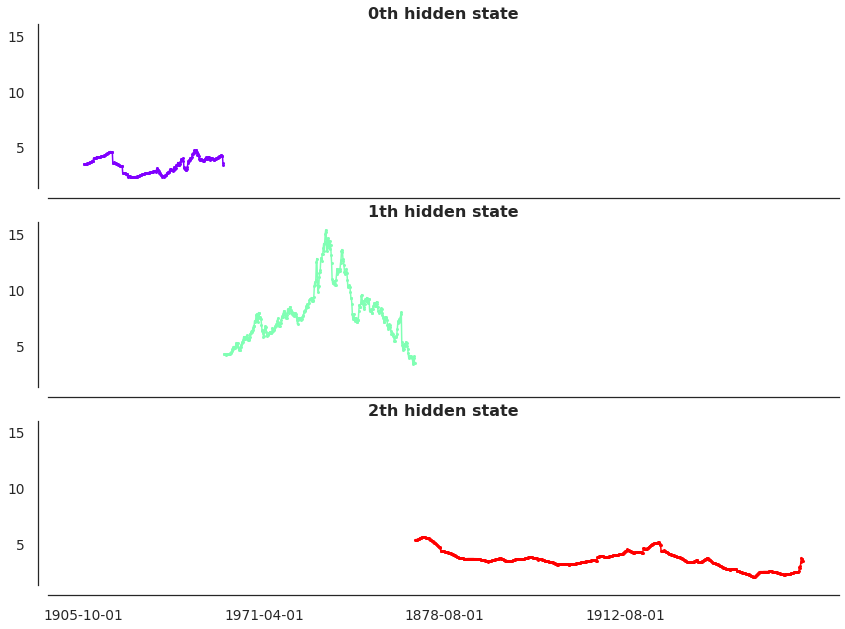

In [215]:
from matplotlib import cm
from matplotlib.dates import YearLocator, MonthLocator
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
#fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

In [216]:
p=print
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['newStates'], index=select.index)
          .join(select, how='inner')
          #.assign(mkt_cret=select.Cluster.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
p(states.head())


         Date  newStates  Real Earnings  Long Interest Rate
0  1871-01-01          2           8.02                5.32
1  1871-05-01          2           8.14                5.33
2  1871-06-01          2           8.27                5.34
3  1871-07-01          2           8.27                5.34
4  1871-08-01          2           8.40                5.34


In [217]:

p(states.head())
newStatesDf = states

newStatesDf.to_csv('df_svm_dataset1.csv')


         Date  newStates  Real Earnings  Long Interest Rate
0  1871-01-01          2           8.02                5.32
1  1871-05-01          2           8.14                5.33
2  1871-06-01          2           8.27                5.34
3  1871-07-01          2           8.27                5.34
4  1871-08-01          2           8.40                5.34


## Local Model 2- SVM

In [223]:
states2 = pd.read_csv('df_svm_dataset1_oldandnew.csv', header=0)
#states = states.set_index('Date')
states2 = states2[['Real Earnings', 'Long Interest Rate', 'newStates']]
states2

,Real Earnings,Long Interest Rate,newStates
0,8.02,5.32,2
1,8.14,5.33,2
2,8.27,5.34,2
3,8.27,5.34,2
4,8.40,5.34,2
...,...,...,...
1889,45.12,3.57,2
1890,46.99,3.33,2
1891,48.76,3.98,2
1892,41.06,3.81,1


In [225]:
from sklearn.model_selection import train_test_split
y = states2['newStates']
X = states2.drop(['newStates'], axis = 1)

training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .25, random_state = 42)

In [ ]:
# X = states2.drop(['states'], axis = 1)
# # Normalize the data
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# normed_train_data = pd.DataFrame(sc.fit_transform(training), columns = X.columns)
# normed_test_data = pd.DataFrame(sc.fit_transform(testing), columns = X.columns)

In [226]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(training, training_labels)

#Predict the response for test dataset
y_pred = clf.predict(testing)



In [227]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(testing_labels, y_pred))

Accuracy: 0.8945147679324894


In [228]:
from sklearn.metrics import f1_score
print("f-score testing macro: " , f1_score(testing_labels, y_pred, average='macro') )

f-score testing macro:  0.8724434555899435


## Local model 3: SVM - Current Scenario: New accuracy < Old accuracy
As the new accuracy is less than old accuracy we now only train the new dataset.

In [287]:
states3 = pd.read_csv('df_states_newDatapoints.csv', header=0)
#states = states.set_index('Date')
states3 = states3[['newStates','Real Earnings', 'Long Interest Rate']]
states3

,newStates,Real Earnings,Long Interest Rate
0,2,8.02,5.32
1,2,8.14,5.33
2,2,8.27,5.34
3,2,8.27,5.34
4,2,8.40,5.34
...,...,...,...
1452,2,10.66,3.56
1453,2,12.57,3.59
1454,2,14.51,3.40
1455,0,29.30,3.39


In [288]:
from sklearn.model_selection import train_test_split
y = states3['newStates']
X = states3.drop(['newStates'], axis = 1)

training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .30, random_state = 42)

In [289]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(training, training_labels)

#Predict the response for test dataset
y_pred = clf.predict(testing)



In [290]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(testing_labels, y_pred))

Accuracy: 0.9954337899543378


In [291]:
from sklearn.metrics import f1_score
print("f-score testing macro: " , f1_score(testing_labels, y_pred, average='macro') )

f-score testing macro:  0.9950934649393742
